# 0. Install Dependencies and Bring in Data

In [2]:
!pip install pandas

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.5 MB 6.3 MB/s eta 0:00:02
   --------- ------------------------------ 2.6/11.5 MB 7.2 MB/s eta 0:00:02
   ---------------- ----------------------- 4.7/11.5 MB 7.9 MB/s eta 0:00:01
   ---------------------- ----------------- 6.6/11.5 MB 8.1 MB/s eta 0:00:01
   ---------------------------- ----------- 8.1/11.5 MB 8.1 MB/s eta 0:00:01
   ------------------------------- -------- 9.2/11.5 MB 7.6 MB/s eta 0:00:01
   ------------------------------------- -- 10.7/11.5 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 7.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [17]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [18]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [7]:
!pip list

Package                        Version
------------------------------ ---------------
absl-py                        2.1.0
anyio                          4.2.0
argon2-cffi                    23.1.0
argon2-cffi-bindings           21.2.0
arrow                          1.3.0
asttokens                      2.4.1
astunparse                     1.6.3
async-lru                      2.0.4
attrs                          23.2.0
Babel                          2.14.0
beautifulsoup4                 4.12.3
bleach                         6.1.0
certifi                        2024.2.2
cffi                           1.16.0
charset-normalizer             3.3.2
colorama                       0.4.6
comm                           0.2.1
debugpy                        1.8.0
decorator                      5.1.1
defusedxml                     0.7.1
dm-tree                        0.1.8
executing                      2.0.1
fastjsonschema                 2.19.1
flatbuffers                    24.3.25
fqdn          

In [19]:
from tensorflow.keras.layers import TextVectorization

In [20]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [21]:
MAX_FEATURES = 200000 # number of words in the vocab

In [22]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [8]:
vectorizer.adapt(X.values)

In [9]:
vectorized_text = vectorizer(X.values)

In [10]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [11]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [13]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [14]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3842s 549ms/step - loss: 0.0837 - val_loss: 0.0443


In [26]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

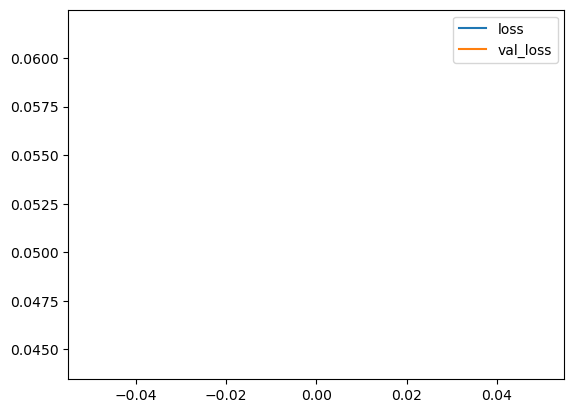

In [27]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [28]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [29]:
# Ensure the input is shaped correctly for the model
input_text = tf.expand_dims(input_text, axis=0)  # Add batch dimension

In [30]:
res = model.predict(input_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


In [31]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [32]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [33]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [34]:
res.shape

(1, 6)

# 4. Evaluate Model

In [35]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [37]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [38]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8443160057067871, Recall:0.6251069903373718, Accuracy:0.47342026233673096


# 5. Test and Gradio

In [39]:
!pip install gradio jinja2

  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached starlette-0.41.3-py3-none-any.whl.metadata (6.0 kB)
  Using cached httpcore-1.0.7-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
   ---------------------------------------- 0.0/57.6 MB ? eta -:--:--
   - -------------------------------------- 2.1/57.6 MB 9.8 MB/s eta 0:00:06
   - -------------------------------------- 2.6/57.6 MB 6.9 MB/s eta 0:00:09
   --- ------------------------------------ 4.5/57.6 MB 7.3 MB/s eta 0:00:08
   ---- ----------------------------------- 6.3/57.6 MB 7.6 MB/s eta 0:00:07
   ----- ---------------------------------- 8.1/57.6 MB 7.6 MB/s eta 0:00:07
   ------ --------------------------------- 9.7/57.6 MB 7.7 MB/s eta 0

In [1]:
import tensorflow as tf
import gradio as gr

c:\Users\ms848\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model.save('toxicity.h5')#pip install tensorflowjs
# tensorflowjs_converter --input_format keras model.h5 web_model/pip install tensorflowjs
# tensorflowjs_converter --input_format keras model.h5 web_model/')

In [2]:
model = tf.keras.models.load_model('toxicity.h5')

In [3]:
input_str = vectorizer('hey i freaken hate you!')

NameError: name 'vectorizer' is not defined

In [4]:
res = model.predict(np.expand_dims(input_str,0))

NameError: name 'np' is not defined

In [5]:
res

NameError: name 'res' is not defined

In [5]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [6]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [7]:
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://a2e5ea8c3de36cd4c8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "c:\Users\ms848\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ms848\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ms848\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 2220, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ms848\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1731, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ms848\AppData\Local\P